In [1]:
%matplotlib inline
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.data as Data
import torchvision
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from sklearn.metrics import r2_score
from torch import nn, optim
from torch.autograd import Variable
from torch_lr_finder import LRFinder

np.random.seed(14)  # For reproducibility
torch.manual_seed(14);  # For reproducibility

In [2]:
from L96_model import (
    L96,
    RK2,
    RK4,
    EulerFwd,
    L96_eq1_xdot,
    integrate_L96_2t,
)

In [3]:
time_method = RK4

In [4]:
# - a GCM class without any parameterization
class GCM_no_param:
    def __init__(self, F, time_stepping=time_method):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [5]:
# - a GCM class including a linear parameterization in rhs of equation for tendency
class GCM:
    def __init__(self, F, parameterization, time_stepping=time_method):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        return L96_eq1_xdot(X, self.F) - self.parameterization(param, X)

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [6]:
# - a GCM class including a neural network parameterization in rhs of equation for tendency
class GCM_network:
    def __init__(self, F, network, time_stepping=time_method):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, param):
        if self.network.linear1.in_features == 1:
            X_torch = torch.from_numpy(X).double()
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0)).double()
        return L96_eq1_xdot(X, self.F) + np.squeeze(
            self.network(X_torch).data.numpy()
        )  # Adding NN parameterization

    def __call__(self, X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [7]:
time_steps = 20000
Forcing, dt, T = 18, 0.01, 0.01 * time_steps

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=Forcing)

In [8]:
# Get training data for the neural network.

# - Run the true state and output subgrid tendencies (the effect of Y on X is xytrue):
Xtrue, _, _, xytrue = W.run(dt, T, store=True, return_coupling=True)
gcm_no_param = GCM_no_param(Forcing)

In [9]:
val_size = 4000  # number of time steps for validation


# train:
Xtrue_train = Xtrue[
    :-val_size, :
]  # Flatten because we first use single input as a sample
subgrid_tend_train = xytrue[:-val_size, :]

# test:
Xtrue_test = Xtrue[-val_size:, :]
subgrid_tend_test = xytrue[-val_size:, :]

In [10]:
# Define a data loader

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
local_torch_dataset = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_train, -1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_train, -1)).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader_local = Data.DataLoader(
    dataset=local_torch_dataset, batch_size=BATCH_SIZE, shuffle=True
)

In [11]:
# Define a test dataloader

local_torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(np.reshape(Xtrue_test, -1)).double(),
    torch.from_numpy(np.reshape(subgrid_tend_test, -1)).double(),
)

loader_local_test = Data.DataLoader(
    dataset=local_torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

tensor([12.9715,  5.3797,  0.8659,  ..., -0.2063, -1.7095, -4.3625],
       dtype=torch.float64)
tensor([-7.5589, -6.6147, -0.8452,  ...,  0.8405,  2.5118,  3.4432],
       dtype=torch.float64)


Text(0, 0.5, 'subgrid tendency')

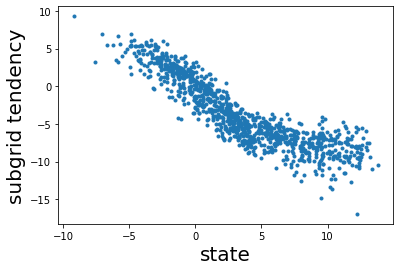

In [12]:
dataiter = iter(loader_local)  # iterating over the data to get one batch
X_iter, subgrid_tend_iter = dataiter.next()

print(X_iter)
print(subgrid_tend_iter)

fontsize = 20
plt.plot(X_iter, subgrid_tend_iter, ".")
plt.xlabel("state", fontsize=fontsize)
plt.ylabel("subgrid tendency", fontsize=fontsize)

In [13]:
# define a network structure in pytorch (here it is a linear network)
class linear_reg(nn.Module):
    def __init__(self):
        super(linear_reg, self).__init__()
        self.linear1 = nn.Linear(1, 1)  # a single input and a single output

    def forward(
        self, x
    ):  # when calling the model ('linear_reg(input)') it calls automatically the forward method we defined (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
        x = self.linear1(x)
        return x

In [14]:
lin_net = linear_reg().double()
print(lin_net)

linear_reg(
  (linear1): Linear(in_features=1, out_features=1, bias=True)
)


In [15]:
# An example of how to plug a sample into the network
input1 = torch.randn(1, 1).double()
out = lin_net(input1)
# when calling the model ('lin_net(input)') it calls automatically the forward method we defined (via __call__ - see https://github.com/pytorch/pytorch/blob/472be69a736c0b2aece4883be9f8b18e2f3dfbbd/torch/nn/modules/module.py#L487)
print("The output of the random input is:", out.detach().numpy())

The output of the random input is: [[-0.05858676]]


In [16]:
criterion = torch.nn.MSELoss()  # MSE loss function
X_tmp = next(iter(loader_local))

y_tmp = lin_net(torch.unsqueeze(X_tmp[0], 1))  # Predict
loss = criterion(y_tmp, torch.unsqueeze(X_tmp[1], 1))  # calculate the MSE loss loss

In [17]:
lin_net.zero_grad()  # zeroes the gradient buffers of all parameters

print("conv1.bias.grad before backward")
print(lin_net.linear1.bias.grad)

loss.backward(
    retain_graph=True
)  # Computes the gradient of all components current tensor

print("conv1.bias.grad after backward")
print(lin_net.linear1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([14.0364], dtype=torch.float64)


In [18]:
optimizer = optim.SGD(lin_net.parameters(), lr=0.003, momentum=0.9)
print("Before backward pass: \n", list(lin_net.parameters())[0].data.numpy())
loss.backward(retain_graph=True)
optimizer.step()
print("After backward pass: \n", list(lin_net.parameters())[0].data.numpy())

Before backward pass: 
 [[0.65897453]]
After backward pass: 
 [[-0.06057031]]


In [19]:
def train_model(net, criterion, trainloader, optimizer):
    net.train()
    test_loss = 0
    for step, (batch_x, batch_y) in enumerate(trainloader):  # for each training step
        b_x = Variable(batch_x)  # Inputs
        b_y = Variable(batch_y)  # outputs
        if (
            len(b_x.shape) == 1
        ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
            prediction = torch.squeeze(
                net(torch.unsqueeze(b_x, 1))
            )  # input x and predict based on x
        else:
            prediction = net(b_x)
        loss = criterion(prediction, b_y)  # Calculating loss
        optimizer.zero_grad()  # clear gradients for next train
        loss.backward()  # backpropagation, compute gradients
        optimizer.step()  # apply gradients to update weights


#         test_loss = test_loss + loss.data.numpy() # Keep track of the loss for convenience
#     test_loss /= len(trainloader) # dividing by the number of batches
#     print('the loss in this Epoch',test_loss)
#     print(b_y.shape)
#     print(prediction.shape)

In [20]:
def test_model(net, criterion, trainloader, optimizer, text="validation"):
    net.eval()  # Evaluation mode (important when having dropout layers)
    test_loss = 0
    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(
            trainloader
        ):  # for each training step
            b_x = Variable(batch_x)  # Inputs
            b_y = Variable(batch_y)  # outputs
            if (
                len(b_x.shape) == 1
            ):  # If is needed to add a dummy dimension if our inputs are 1D (where each number is a different sample)
                prediction = torch.squeeze(
                    net(torch.unsqueeze(b_x, 1))
                )  # input x and predict based on x
            else:
                prediction = net(b_x)
            loss = criterion(prediction, b_y)  # Calculating loss
            test_loss = test_loss + loss.data.numpy()  # Keep track of the loss
        test_loss /= len(trainloader)  # dividing by the number of batches
        #         print(len(trainloader))
        print(text + " loss:", test_loss)
    return test_loss

In [21]:
n_epochs = 3  # Number of epocs (the number of times we iterate over the training data during training)
optimizer = optim.Adam(
    lin_net.parameters(), lr=0.03
)  # If we have time we can discuss later the Adam optimizer
for epoch in range(1, n_epochs + 1):
    train_model(lin_net, criterion, loader_local, optimizer)
    test_model(lin_net, criterion, loader_local, optimizer, "train")
    test_model(lin_net, criterion, loader_local_test, optimizer)

train loss: 4.01076766397729
validation loss: 4.021152039673325


train loss: 4.003080934482223


validation loss: 4.003328110206599


train loss: 3.9984006864662147
validation loss: 4.0310886067231575


In [22]:
print(lin_net.linear1.weight.data.numpy())
print(lin_net.linear1.bias.data.numpy())

[[-0.85209807]]
[-0.77366882]


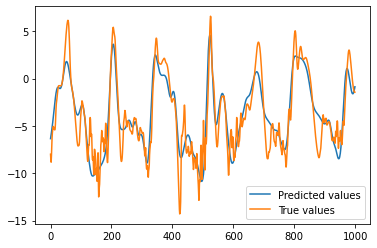

In [23]:
preds22 = lin_net(
    torch.unsqueeze(torch.from_numpy(np.reshape(Xtrue_test[:, 1], -1)).double(), 1)
)
plt.plot(preds22.detach().numpy()[0:1000], label="Predicted values")
plt.plot(subgrid_tend_test[:1000, 1], label="True values")

plt.legend();

In [24]:
T_test = 10

X_full, _, _ = W.run(dt, T_test)  # Full model


init_cond = Xtrue[-1, :]

gcm_net = GCM_network(Forcing, lin_net)
Xnn_1layer, t = gcm_net(init_cond, dt, int(T_test / dt), lin_net)

gcm_no_param = GCM_no_param(Forcing)
X_no_param, t = gcm_no_param(init_cond, dt, int(T_test / dt))


naive_parameterization = lambda param, X: np.polyval(param, X)
gcm = GCM(Forcing, naive_parameterization)
X_param, t = gcm(init_cond, dt, int(T / dt), param=[0.85439536, 1.75218026])

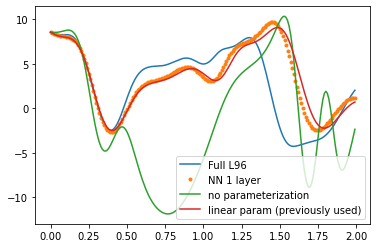

In [25]:
time_i = 200
plt.plot(t[:time_i], X_full[:time_i, 4], label="Full L96")
plt.plot(t[:time_i], Xnn_1layer[:time_i, 4], ".", label="NN 1 layer")
plt.plot(t[:time_i], X_no_param[:time_i, 4], label="no parameterization")
plt.plot(t[:time_i], X_param[:time_i, 4], label="linear param (previously used)")

plt.legend();

In [26]:
# Create non local training data
# Define a data loader (8 inputs, 8 outputs)

# Define our X,Y pairs (state, subgrid tendency) for the linear regression local network.local_torch_dataset = Data.TensorDataset(
torch_dataset = Data.TensorDataset(
    torch.from_numpy(Xtrue_train).double(),
    torch.from_numpy(subgrid_tend_train).double(),
)

BATCH_SIZE = 1024  # Number of sample in each batch

loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
# Define a test dataloader (8 inputs, 8 outputs)

torch_dataset_test = Data.TensorDataset(
    torch.from_numpy(Xtrue_test).double(), torch.from_numpy(subgrid_tend_test).double()
)

loader_test = Data.DataLoader(
    dataset=torch_dataset_test, batch_size=BATCH_SIZE, shuffle=True
)

In [28]:
# define network structure in pytorch
import torch.nn.functional as FF


class Net_ANN(nn.Module):
    def __init__(self):
        super(Net_ANN, self).__init__()
        self.linear1 = nn.Linear(8, 16)  # 8 inputs, 16 neurons for first hidden layer
        self.linear2 = nn.Linear(16, 16)  # 16 neurons for second hidden layer
        self.linear3 = nn.Linear(16, 8)  # 8 outputs

    #         self.lin_drop = nn.Dropout(0.1) #regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = FF.relu(self.linear2(x))
        x = self.linear3(x)
        return x

Text(0.5, 1.0, 'ReLU')

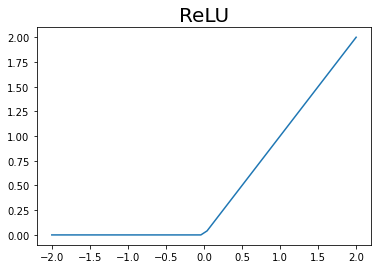

In [29]:
x = np.linspace(-2, 2, 50)
plt.plot(x, np.maximum(x, 0))
plt.title("ReLU", fontsize=20)

In [30]:
torch.manual_seed(14)  # For reproducibility
nn_3l = Net_ANN().double()

train loss: 30.11752312633508
validation loss: 30.118915290524914
train loss: 19.44188452003369
validation loss: 19.567465155549137


train loss: 12.673455156588787
validation loss: 12.72573836248402


train loss: 8.981023541039761
validation loss: 8.969868011101731
train loss: 7.362135832182051
validation loss: 7.296006627695814


train loss: 6.381767226898048
validation loss: 6.366601982835725
train loss: 5.558710861416543
validation loss: 5.587130341393454


train loss: 4.812780326435144
validation loss: 4.862176965081709


train loss: 4.23814587100924
validation loss: 4.257574305874837
train loss: 3.8931013768725515
validation loss: 3.9217922965884195


train loss: 3.694052399305309
validation loss: 3.6956443625001176
train loss: 3.52405161320218
validation loss: 3.5330761472980696


train loss: 3.3591067958120195
validation loss: 3.352024248938528


train loss: 3.187602301786935
validation loss: 3.1667010885303943
train loss: 3.047532931173087
validation loss: 3.0101967712641526


train loss: 2.944460729527875
validation loss: 2.912183445374992
train loss: 2.8799338816606554
validation loss: 2.8460628369540966


train loss: 2.838346619257628
validation loss: 2.801685128887617


train loss: 2.8051665516835773
validation loss: 2.762506002014553
train loss: 2.782228550938645
validation loss: 2.7278937357954227


train loss: 2.753022763328556
validation loss: 2.7054397176651985
train loss: 2.7320750277068604
validation loss: 2.6929349948085712


train loss: 2.715879991611459
validation loss: 2.657970802398177


train loss: 2.7003958680967663
validation loss: 2.640571809321296
train loss: 2.685637743654191
validation loss: 2.627313979835866


train loss: 2.6638737892819737
validation loss: 2.6151054896122217
train loss: 2.652343404967359
validation loss: 2.6037022389450173


train loss: 2.6370659467170627
validation loss: 2.5820661898720765


train loss: 2.6231860712089237
validation loss: 2.578107164629894
train loss: 2.6155459691546956
validation loss: 2.574426232391399


train loss: 2.603092812587362
validation loss: 2.564002499837138
train loss: 2.5973341212300465
validation loss: 2.5422291587525403


train loss: 2.5854734335247906
validation loss: 2.534587076692971


train loss: 2.5774023774964196
validation loss: 2.536986916998388
train loss: 2.5540646085260645
validation loss: 2.5151112992986198


train loss: 2.5609394899646847
validation loss: 2.5079609432472307
train loss: 2.54223911858353
validation loss: 2.5030648191402176


train loss: 2.53051602877902
validation loss: 2.487952557358665


train loss: 2.5276674647137933
validation loss: 2.5135119416359366
train loss: 2.513855857196844
validation loss: 2.488129081876798


train loss: 2.503379144873901
validation loss: 2.472402509165546
train loss: 2.5025975309751725
validation loss: 2.475460231317543


train loss: 2.4936068466382855
validation loss: 2.4531874523409836


train loss: 2.4805978975745306
validation loss: 2.453262146686764
train loss: 2.4749361708613353
validation loss: 2.4467389212641466


train loss: 2.47152368112684
validation loss: 2.4364656739260946


train loss: 2.4589943382976376
validation loss: 2.4327517658263944
train loss: 2.4579898827466824
validation loss: 2.43055390960033


train loss: 2.455973916250345
validation loss: 2.434120381955682
train loss: 2.444197501459908
validation loss: 2.4206268797585704


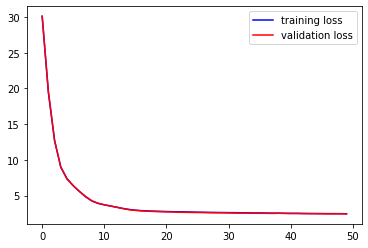

In [31]:
n_epochs = 50  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

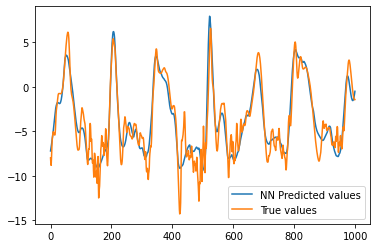

In [32]:
preds22 = nn_3l(torch.from_numpy(Xtrue_test[:, :]).double())
plt.plot(preds22.detach().numpy()[0:1000, 1], label="NN Predicted values")
plt.plot(subgrid_tend_test[:1000, 1], label="True values")

plt.legend();

In [33]:
T_test = 5

# X_full,_,_ = W.run(dt, T_test) # Full model

gcm_net_3layers = GCM_network(Forcing, nn_3l)
Xnn_3layer, t = gcm_net_3layers(init_cond, dt, int(T_test / dt), nn_3l)

gcm_net_1layers = GCM_network(Forcing, lin_net)
Xnn_1layer, t = gcm_net_1layers(init_cond, dt, int(T_test / dt), lin_net)

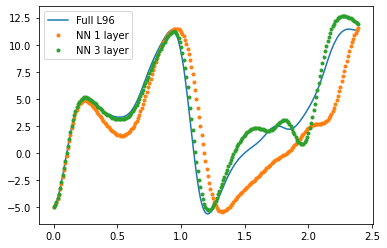

In [34]:
time_i = 240
channel = 1
plt.plot(t[:time_i], X_full[:time_i, channel], label="Full L96")
plt.plot(t[:time_i], Xnn_1layer[:time_i, channel], ".", label="NN 1 layer")
plt.plot(t[:time_i], Xnn_3layer[:time_i, channel], ".", label="NN 3 layer")

plt.legend();

In [35]:
# Checking over 100 different initial conditions...
err1L = list()
err3L = list()
T_test = 1
for i in range(100):
    init_cond_temp = Xtrue[i * 10, :]
    gcm_net_3layers = GCM_network(Forcing, nn_3l)
    Xnn_3layer_tmp, t = gcm_net_3layers(init_cond_temp, dt, int(T_test / dt), nn_3l)

    gcm_net_1layers = GCM_network(Forcing, lin_net)
    Xnn_1layer_tmp, t = gcm_net_1layers(init_cond_temp, dt, int(T_test / dt), lin_net)

    err1L.append(
        np.sum(np.abs(Xtrue[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_1layer_tmp))
    )
    err3L.append(
        np.sum(np.abs(Xtrue[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_3layer_tmp))
    )
print("Sum of errors for 1 layer:", sum(err1L))
print("Sum of errors for 3 layer:", sum(err3L))

Sum of errors for 1 layer: 54971.36229282367
Sum of errors for 3 layer: 36070.43440283795


train loss: 2.4408587043468843
validation loss: 2.4213647535523988
train loss: 2.428500583395654
validation loss: 2.405385159083399


train loss: 2.4357470327151094
validation loss: 2.4044560689621353


train loss: 2.420948340009739
validation loss: 2.389287121390715
train loss: 2.416438769080365
validation loss: 2.3892660656403595


train loss: 2.4244442770046337
validation loss: 2.405037598432258
train loss: 2.4083108148786687
validation loss: 2.389884834000205


train loss: 2.410283625800936
validation loss: 2.394719340928746


train loss: 2.39795204371508
validation loss: 2.380536194899771
train loss: 2.399532217591545
validation loss: 2.382214012291626


train loss: 2.3960342798560568
validation loss: 2.383437811826909
train loss: 2.395200808643063
validation loss: 2.3705142418785234


train loss: 2.3852695570219717
validation loss: 2.369489818589196


train loss: 2.3871928179757997
validation loss: 2.3725517410078862
train loss: 2.3799743290996282
validation loss: 2.3721497096066537


train loss: 2.386048625727647
validation loss: 2.3765668689121164
train loss: 2.377760978558799
validation loss: 2.362588752537961


train loss: 2.378377112626845
validation loss: 2.355645933940844


train loss: 2.3711650215396896
validation loss: 2.357368646630867
train loss: 2.3717977146419713
validation loss: 2.366979911807779


train loss: 2.3735674607832706
validation loss: 2.3855926803704586
train loss: 2.372574521280996
validation loss: 2.3561122803070016


train loss: 2.3624850255490073
validation loss: 2.3714208585082837


train loss: 2.3649363797037783
validation loss: 2.372884335071281
train loss: 2.3647287648486746
validation loss: 2.361980905945559


train loss: 2.3616836919327886
validation loss: 2.3490095451146793
train loss: 2.3584875752596393
validation loss: 2.3561648458291717


train loss: 2.3516062265043174
validation loss: 2.358229746176712


train loss: 2.346734691765249
validation loss: 2.342416645693179
train loss: 2.345094825746397
validation loss: 2.3498438933862893


train loss: 2.345456936048083
validation loss: 2.357108937610559
train loss: 2.3460215494037455
validation loss: 2.3429973465658724


train loss: 2.342429386978328
validation loss: 2.3463013815360516


train loss: 2.3414386351829783
validation loss: 2.3509084211155944
train loss: 2.3401221158972003
validation loss: 2.336948200156332


train loss: 2.333802624072077
validation loss: 2.3380931075115177
train loss: 2.337894879324235
validation loss: 2.3375296623214648


train loss: 2.337234026747268
validation loss: 2.339698512369589


train loss: 2.3321143463927823
validation loss: 2.331406080214435
train loss: 2.3355529308757665
validation loss: 2.3394824083970276


train loss: 2.3327059068240357
validation loss: 2.339833299244644
train loss: 2.3327386457296373
validation loss: 2.3348442750833636


train loss: 2.327918545576475
validation loss: 2.3228830526692796


train loss: 2.330542786053134
validation loss: 2.3311433815443063
train loss: 2.328974130241215
validation loss: 2.329339280537101


train loss: 2.3267540127254938
validation loss: 2.3367208953650085


train loss: 2.3206352892351485
validation loss: 2.333688027564039
train loss: 2.3194485732502113
validation loss: 2.328281720479672


train loss: 2.3140792108029618
validation loss: 2.3370858916284303
train loss: 2.312097747806184
validation loss: 2.327747649078053


train loss: 2.320199718138595
validation loss: 2.3312443839706694
train loss: 2.313580960267741
validation loss: 2.327683633409608


train loss: 2.3051576264808764
validation loss: 2.316343218282113


train loss: 2.3057998738507357
validation loss: 2.325201002643615
train loss: 2.304290440037695
validation loss: 2.3230905636255224


train loss: 2.2990677760159692
validation loss: 2.3271583947933197


train loss: 2.301027221342312
validation loss: 2.3167075359343277
train loss: 2.306520177471024
validation loss: 2.321396691570565


train loss: 2.296583929696083
validation loss: 2.3120568129340784
train loss: 2.293456195992035
validation loss: 2.3198547004490773


train loss: 2.293314561566951
validation loss: 2.315991348524232


train loss: 2.291805921493312
validation loss: 2.3270394900642146
train loss: 2.28918408731107
validation loss: 2.3173964955224187


train loss: 2.2887664612065697
validation loss: 2.3040361954807613
train loss: 2.286187587205157
validation loss: 2.3107836577559437


train loss: 2.2853573473982003
validation loss: 2.3017049637823916
train loss: 2.289296841027923
validation loss: 2.3213164659675174


train loss: 2.282337942095583
validation loss: 2.30161773287255


train loss: 2.2886766207482436
validation loss: 2.3019458063436815
train loss: 2.2805311927947396
validation loss: 2.308542371302153


train loss: 2.278155333481558
validation loss: 2.296195379853491
train loss: 2.270331189553331
validation loss: 2.2964142204709996


train loss: 2.2699844896571415
validation loss: 2.2970943552017804


train loss: 2.2674283133371755
validation loss: 2.2974872934788624
train loss: 2.265772660537026
validation loss: 2.303896661322585


train loss: 2.2681946676609934
validation loss: 2.3016662216555854


train loss: 2.2633390253924888
validation loss: 2.2943714897381535
train loss: 2.2633629571938294
validation loss: 2.2903599015561014


train loss: 2.255213130944466
validation loss: 2.2834698409496066
train loss: 2.264718271580632
validation loss: 2.295919789369503


train loss: 2.249288355863724
validation loss: 2.276713863039762
train loss: 2.2532060536803127
validation loss: 2.285364810871843


train loss: 2.242722279014874
validation loss: 2.27721460425547


train loss: 2.23885939612036
validation loss: 2.2733829266764705
train loss: 2.235599485441473
validation loss: 2.278003434848084


train loss: 2.24222755696246
validation loss: 2.2930016524601093


train loss: 2.2345977417121965
validation loss: 2.2728562395853498
train loss: 2.228785411457629
validation loss: 2.2726401065982653


train loss: 2.22978235969004
validation loss: 2.270920309002026
train loss: 2.2292302741159205
validation loss: 2.2646195115491183


train loss: 2.2264625623155903
validation loss: 2.261553639209969


train loss: 2.218506212531442
validation loss: 2.2606892057084935
train loss: 2.2188501992937617
validation loss: 2.2654442248378173


train loss: 2.2208154957643846
validation loss: 2.2754357501192173
train loss: 2.2198400666871763
validation loss: 2.261092035187028


train loss: 2.222604676386533
validation loss: 2.2634787319007357
train loss: 2.217198572589525
validation loss: 2.251840944386916


train loss: 2.2164416488814425
validation loss: 2.26603528850364


train loss: 2.207713735674297
validation loss: 2.2509325997006537
train loss: 2.214824271517468
validation loss: 2.2565728586510443


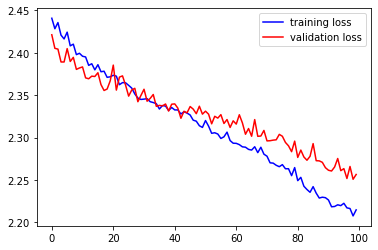

In [36]:
n_epochs = 100  # Number of epocs
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

In [37]:
# Save network
PATH = "network_3_layers_100_epoches.pth"
torch.save(nn_3l.state_dict(), PATH)

# Load network
# path_load = 'network_3_layers_100_epoches.pth'
# nn_3l.load_state_dict(torch.load(path_load))

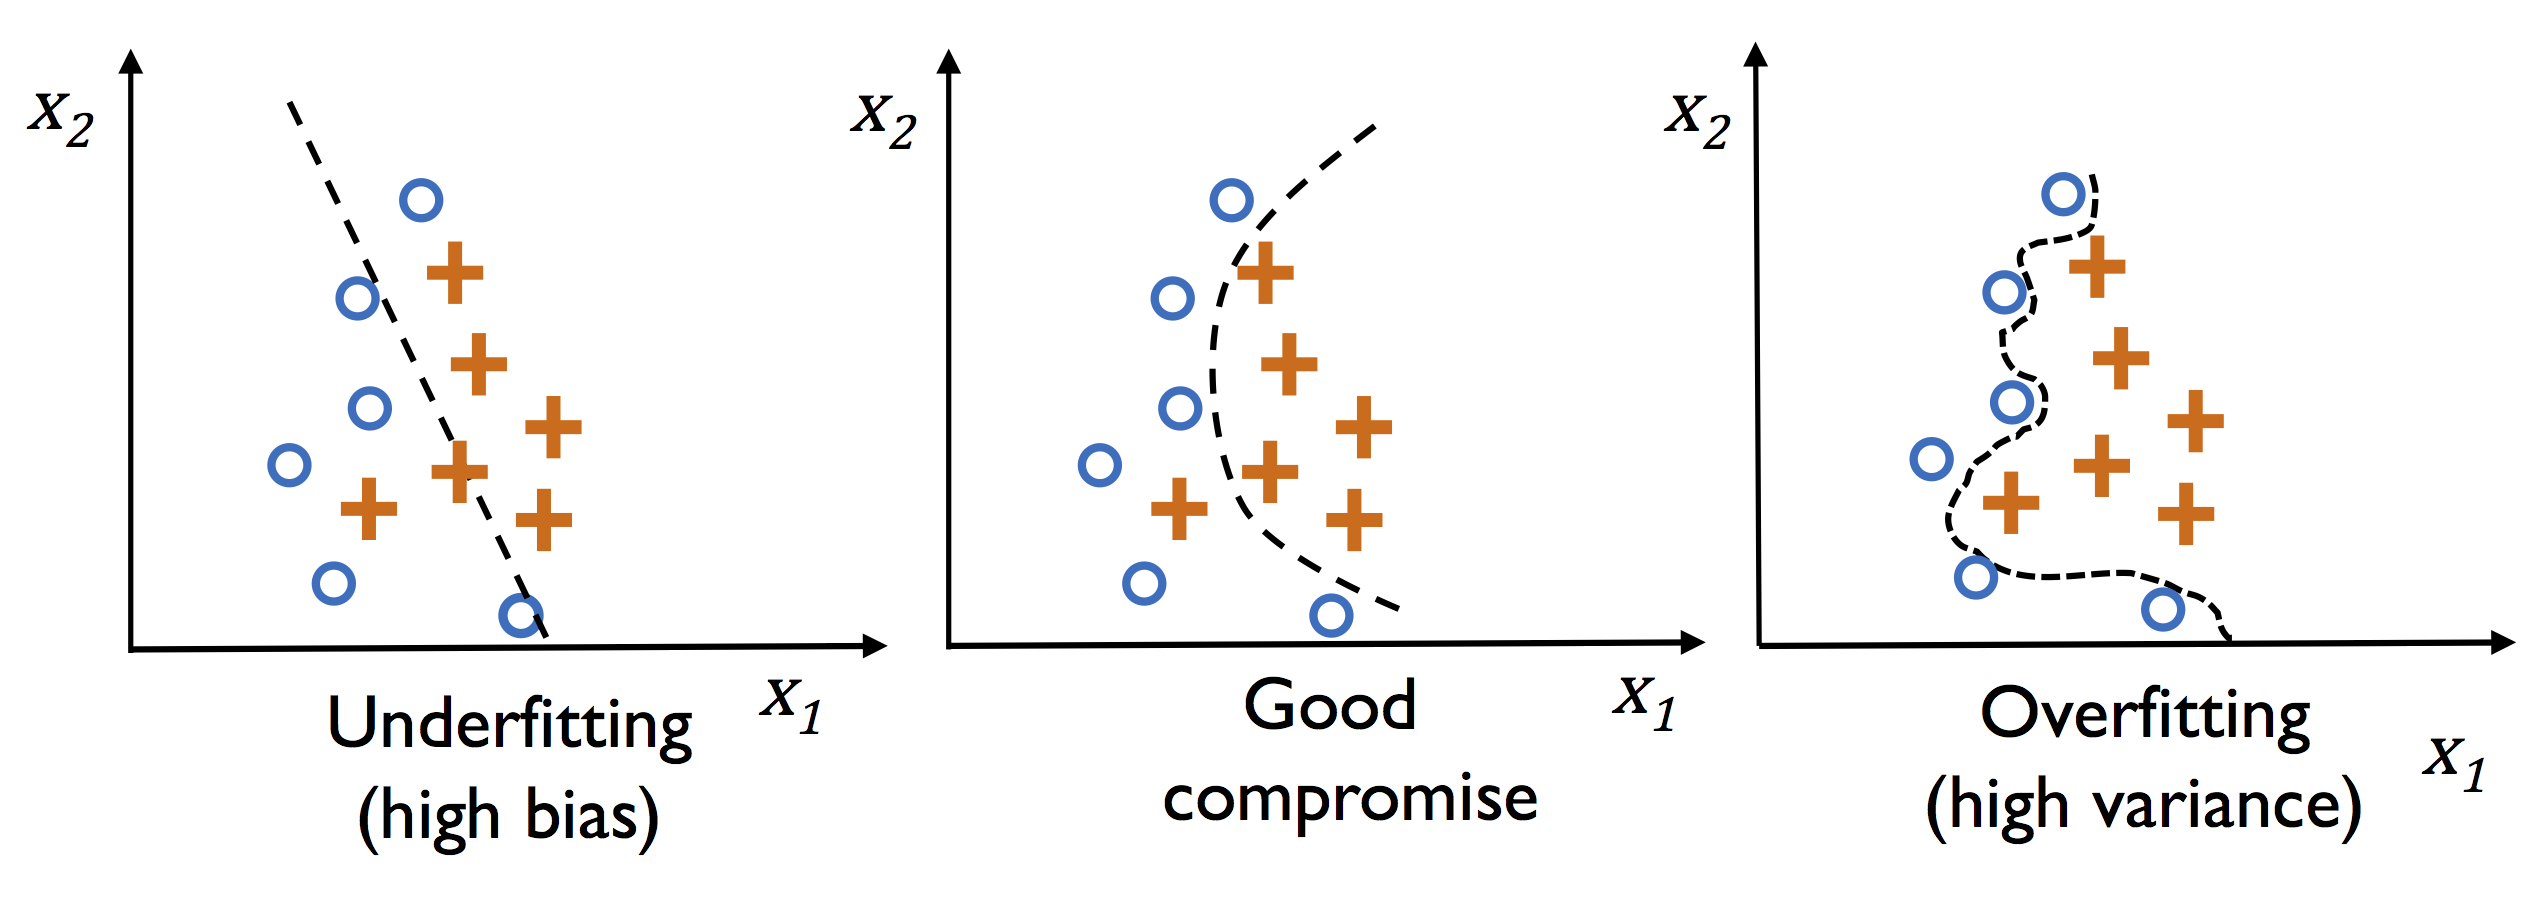

In [38]:
from IPython.display import Image

Image(filename="figs/overfitting.png", width=700)
# The figure below is taken from Python Machine Learning book by Sebastian Raschka

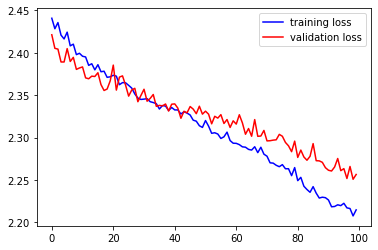

In [39]:
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

train loss: 2.2431410504998213
validation loss: 2.2853458929863057
train loss: 2.2470188873872106
validation loss: 2.280711157222979


train loss: 2.2597580785565774
validation loss: 2.2922189713081966


train loss: 2.2764723514954555
validation loss: 2.3136280333309114
train loss: 2.290990025062774
validation loss: 2.3240843045757513


train loss: 2.3005119408301598
validation loss: 2.337053417117639
train loss: 2.305632077995302
validation loss: 2.3331388397723662


train loss: 2.3123558877316617
validation loss: 2.3327361249297134


train loss: 2.320111462803631
validation loss: 2.3450140628145593
train loss: 2.3290133773378856
validation loss: 2.3534039377372054


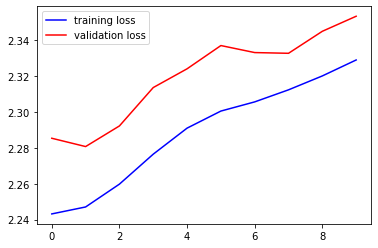

In [40]:
n_epochs = 10  # Number of epocs
optimizer = optim.Adam(nn_3l.parameters(), lr=0.003, weight_decay=0.1)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

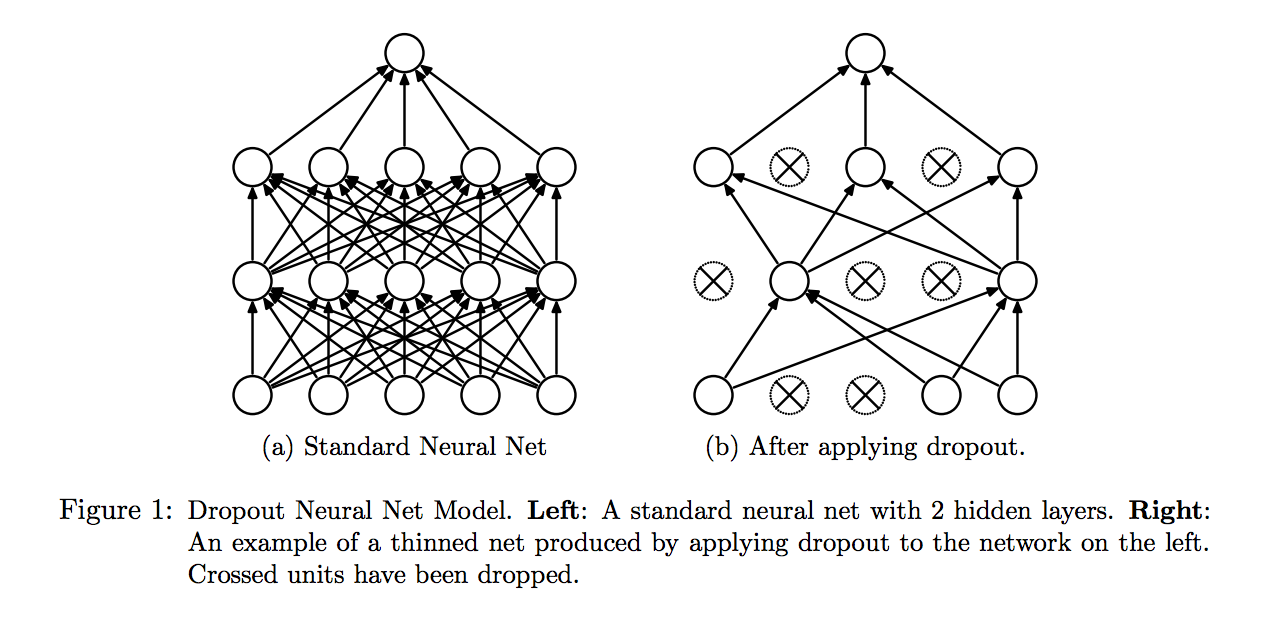

In [41]:
# Image taken from: http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf
Image(filename="figs/Dropout_layer.png", width=700)

In [42]:
# define network structure in pytorch


class Net_ANN_dropout(nn.Module):
    def __init__(self, dropout=0.2):
        super(Net_ANN_dropout, self).__init__()
        self.linear1 = nn.Linear(8, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)
        self.drop = nn.Dropout(dropout)  # regularization method to prevent overfitting.

    def forward(self, x):
        x = FF.relu(self.linear1(x))
        x = self.drop(x)
        x = FF.relu(self.linear2(x))
        x = self.drop(x)
        x = self.linear3(x)
        return x

train loss: 28.69650472196512
validation loss: 28.64811442576358
train loss: 25.774482521111036
validation loss: 25.724438868258883


train loss: 23.764734992224064
validation loss: 23.75139409925143


train loss: 21.60552759271213
validation loss: 21.56475438981205
train loss: 20.343701665780905
validation loss: 20.303509551812105


train loss: 18.92113012340524
validation loss: 18.894497739597494
train loss: 18.039393757814583
validation loss: 17.99769771512417


train loss: 17.3136494297489
validation loss: 17.281711910976224


train loss: 16.795758478787242
validation loss: 16.79426893168961
train loss: 16.24088128473153
validation loss: 16.25001112413357


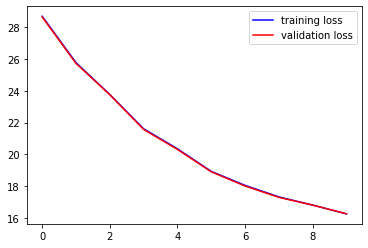

In [43]:
nn_3l_drop = Net_ANN_dropout(dropout=0.8).double()  # Exagerated dropout...
n_epochs = 10  # Number of epocs
optimizer = optim.Adam(nn_3l_drop.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_drop, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_drop, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_drop, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

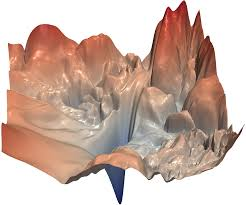

In [44]:
# Image taken from: https://papers.nips.cc/paper/7875-visualizing-the-loss-landscape-of-neural-nets.pdf
Image(filename="figs/Loss_function_vis_NN.jpeg", width=400)

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.29E-02


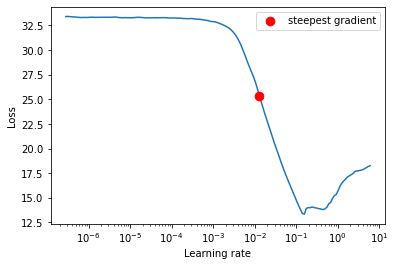

In [45]:
nn_3l_LR = Net_ANN().double()
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state

train loss: 13.817838207034493
validation loss: 13.929791411959432
train loss: 8.226771614476286
validation loss: 8.290345696673075


train loss: 5.637053851147564
validation loss: 5.615243682905206
train loss: 4.111839483694906
validation loss: 4.154723658641473


train loss: 3.470164189380075
validation loss: 3.4714099277549955


train loss: 3.0568650098394725
validation loss: 3.0828191334074604
train loss: 2.9199982855443953
validation loss: 2.95327341762592


train loss: 2.8615812717760996
validation loss: 2.8854955321817544
train loss: 2.7878157966420636
validation loss: 2.7994535825342193


train loss: 2.7337502314673996
validation loss: 2.731262905992316
train loss: 2.6933311910757354
validation loss: 2.6852504093349485


train loss: 2.6587326093219903
validation loss: 2.6400021664837983


train loss: 2.6226903755637103
validation loss: 2.6029073336323343
train loss: 2.5907269916937157
validation loss: 2.585764176172134


train loss: 2.5659613946805333
validation loss: 2.554904630845483


train loss: 2.56006925307251
validation loss: 2.544454986957045
train loss: 2.513115984329809
validation loss: 2.5098973760571974


train loss: 2.501725426920226
validation loss: 2.505503529876583
train loss: 2.478052964210027
validation loss: 2.4807536345426504


train loss: 2.4896449054623244
validation loss: 2.5129688180741976


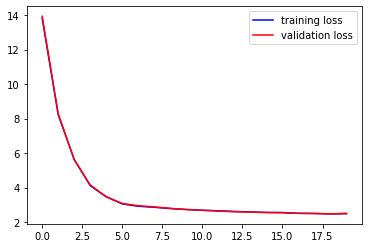

In [46]:
n_epochs = 20  # Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.01)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_LR, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_LR, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.66E-05


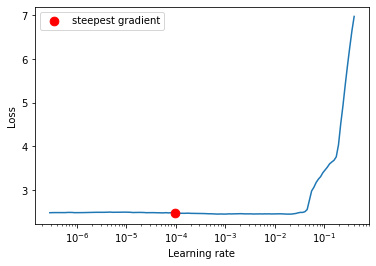

In [47]:
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=1e-7)
lr_finder = LRFinder(nn_3l_LR, optimizer, criterion)
lr_finder.range_test(loader, end_lr=100, num_iter=200)
lr_finder.plot()  # to inspect the loss-learning rate graph
lr_finder.reset()  # to reset the model and optimizer to their initial state

train loss: 2.445316961200866
validation loss: 2.449705032951581
train loss: 2.4404422870062796
validation loss: 2.4451728941227926


train loss: 2.4369246644499456
validation loss: 2.440761539667167


train loss: 2.434152922405941
validation loss: 2.43715929774304
train loss: 2.42816224559029
validation loss: 2.4321935796405736


train loss: 2.4230890155383675
validation loss: 2.4305744534892786
train loss: 2.417524462415921
validation loss: 2.4294636600021526


train loss: 2.4154916825902397
validation loss: 2.425231101694452


train loss: 2.4087833818484983
validation loss: 2.4195215532122414
train loss: 2.403620613597289
validation loss: 2.4164180982533723


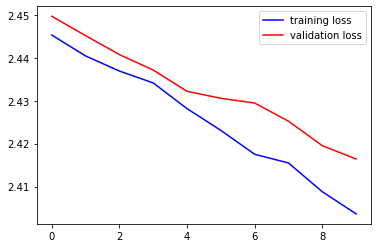

In [48]:
n_epochs = 10  # Number of epocs
optimizer = optim.Adam(nn_3l_LR.parameters(), lr=0.001)
validation_loss = list()
train_loss = list()
# time0 = time()
for epoch in range(1, n_epochs + 1):
    train_model(nn_3l_LR, criterion, loader, optimizer)
    train_loss.append(test_model(nn_3l_LR, criterion, loader, optimizer, "train"))
    validation_loss.append(test_model(nn_3l_LR, criterion, loader_test, optimizer))
plt.plot(train_loss, "b", label="training loss")
plt.plot(validation_loss, "r", label="validation loss")

plt.legend();

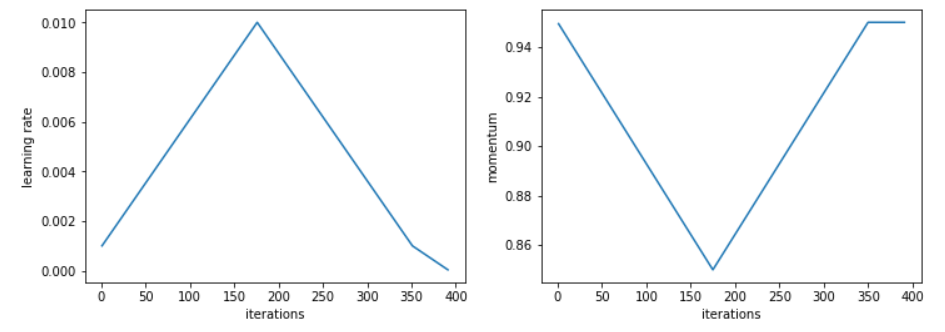

In [49]:
# Image taken from - https://docs.fast.ai/callbacks.one_cycle.html
Image(filename="figs/onecycle_params.png", width=700)